<a href="https://colab.research.google.com/github/budvinchathura/ML-project-drivendata/blob/master/ML_project_drivendata.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [330]:
from google.colab import drive
from IPython.display import display, HTML   # for output formatting
from ipywidgets import widgets, Layout



import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV



In [331]:
# CSS = """
# div.cell:nth-child(5) .output {
#     flex-direction: row;
# }
# """

# CSS = """
# .output {
#     flex-direction: row;
# }
# """

# HTML('<style>{}</style>'.format(CSS))

# test

In [332]:
drive.mount('/content/drive')
train_values_path = 'drive/My Drive/ML-project-drivendata/train_values.csv'
train_labels_path = 'drive/My Drive/ML-project-drivendata/train_labels.csv'
test_values_path = 'drive/My Drive/ML-project-drivendata/test_values.csv'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [333]:
train_values_df = pd.read_csv(train_values_path)
train_labels_df = pd.read_csv(train_labels_path)

train_data_df = pd.merge(train_values_df, train_labels_df, on='id',  how='left')

test_values_df = pd.read_csv(test_values_path)

In [334]:
train_data_df.head()

,id,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,basin,subvillage,region,region_code,district_code,lga,ward,population,public_meeting,recorded_by,scheme_management,scheme_name,permit,construction_year,extraction_type,extraction_type_group,extraction_type_class,management,management_group,payment,payment_type,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group,status_group
0,69572,6000.0,2011-03-14,Roman,1390,Roman,34.938093,-9.856322,none,0,Lake Nyasa,Mnyusi B,Iringa,11,5,Ludewa,Mundindi,109,True,GeoData Consultants Ltd,VWC,Roman,False,1999,gravity,gravity,gravity,vwc,user-group,pay annually,annually,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe,functional
1,8776,0.0,2013-03-06,Grumeti,1399,GRUMETI,34.698766,-2.147466,Zahanati,0,Lake Victoria,Nyamara,Mara,20,2,Serengeti,Natta,280,NaN,GeoData Consultants Ltd,Other,NaN,True,2010,gravity,gravity,gravity,wug,user-group,never pay,never pay,soft,good,insufficient,insufficient,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe,functional
2,34310,25.0,2013-02-25,Lottery Club,686,World vision,37.460664,-3.821329,Kwa Mahundi,0,Pangani,Majengo,Manyara,21,4,Simanjiro,Ngorika,250,True,GeoData Consultants Ltd,VWC,Nyumba ya mungu pipe scheme,True,2009,gravity,gravity,gravity,vwc,user-group,pay per bucket,per bucket,soft,good,enough,enough,dam,dam,surface,communal standpipe multiple,communal standpipe,functional
3,67743,0.0,2013-01-28,Unicef,263,UNICEF,38.486161,-11.155298,Zahanati Ya Nanyumbu,0,Ruvuma / Southern Coast,Mahakamani,Mtwara,90,63,Nanyumbu,Nanyumbu,58,True,GeoData Consultants Ltd,VWC,NaN,True,1986,submersible,submersible,submersible,vwc,user-group,never pay,never pay,soft,good,dry,dry,machine dbh,borehole,groundwater,communal standpipe multiple,communal standpipe,non functional
4,19728,0.0,2011-07-13,Action In A,0,Artisan,31.130847,-1.825359,Shuleni,0,Lake Victoria,Kyanyamisa,Kagera,18,1,Karagwe,Nyakasimbi,0,True,GeoData Consultants Ltd,NaN,NaN,True,0,gravity,gravity,gravity,other,other,never pay,never pay,soft,good,seasonal,seasonal,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe,functional


Explanation of columns

| Column      | Description |
| ----------- | ----------- |
| id      | unique id       |*italicized text*
| amount_tsh | Total static head (amount water available to waterpoint) |
| date_recorded | The date the row was entered |
| funder | Who funded the well |
| gps_height | Altitude of the well |
| installer | Organization that installed the well |
| longitude | GPS coordinate |
| latitude | GPS coordinate |
| wpt_name | Name of the waterpoint if there is one |
| num_private | |
| basin | Geographic water basin |
| subvillage | Geographic location |
| region | Geographic location |
| region_code | Geographic location (coded) |
| district_code | Geographic location (coded) |
| lga | Geographic location |
| ward | Geographic location |
| population | Population around the well |
| public_meeting | True/False |
| recorded_by | Group entering this row of data |
| scheme_management | Who operates the waterpoint |
| scheme_name | Who operates the waterpoint |
| permit | If the waterpoint is permitted |
| construction_year | Year the waterpoint was constructed |
| extraction_type | The kind of extraction the waterpoint uses |
| extraction_type_group | The kind of extraction the waterpoint uses |
| extraction_type_class | The kind of extraction the waterpoint uses |
| management | How the waterpoint is managed |
| management_group | How the waterpoint is managed |
| payment | What the water costs |
| payment_type | What the water costs |
| water_quality | The quality of the water |
| quality_group | The quality of the water |
| quantity | The quantity of water |
| quantity_group | The quantity of water |
| source | The source of the water |
| source_type | The source of the water |
| source_class | The source of the water |
| waterpoint_type | The kind of waterpoint |
| waterpoint_type_group | The kind of waterpoint |
| status_group | working condition (label) <br/> functional / non functional / functional needs repair |

In [335]:
# output = train_data_df.info()._repr_html_() + test_values_df.info()._repr_html_()
# display(HTML(output))

# create output widgets
widget1 = widgets.Output()
widget2 = widgets.Output()

# render in output widgets
with widget1:
    # display.display(df1.style.set_caption('First dataframe'))
    train_data_df.info()
with widget2:
    # display.display(df2.style.set_caption('Second dataframe'))
    test_values_df.info()


# add some CSS styles to distribute free space
box_layout = Layout(display='flex',
                    flex_flow='row',
                    justify_content='space-around',
                    width='auto'
                   )
    
# create Horisontal Box container
hbox = widgets.HBox([widget1, widget2], layout=box_layout)

# render hbox
hbox


In [336]:
print('Zero values of each column in train data\n')
print(train_data_df.apply(lambda col: (col == 0).sum()))

Zero values of each column in train data

id                           1
amount_tsh               41639
date_recorded                0
funder                       0
gps_height               20438
installer                    0
longitude                 1812
latitude                     0
wpt_name                     0
num_private              58643
basin                        0
subvillage                   0
region                       0
region_code                  0
district_code               23
lga                          0
ward                         0
population               21381
public_meeting            5055
recorded_by                  0
scheme_management            0
scheme_name                  0
permit                   17492
construction_year        20709
extraction_type              0
extraction_type_group        0
extraction_type_class        0
management                   0
management_group             0
payment                      0
payment_type                

In [337]:
print('Unique values of each column in train data\n')
print(train_data_df.apply(lambda col: col.nunique()))

Unique values of each column in train data

id                       59400
amount_tsh                  98
date_recorded              356
funder                    1897
gps_height                2428
installer                 2145
longitude                57516
latitude                 57517
wpt_name                 37400
num_private                 65
basin                        9
subvillage               19287
region                      21
region_code                 27
district_code               20
lga                        125
ward                      2092
population                1049
public_meeting               2
recorded_by                  1
scheme_management           12
scheme_name               2696
permit                       2
construction_year           55
extraction_type             18
extraction_type_group       13
extraction_type_class        7
management                  12
management_group             5
payment                      7
payment_type              

Following columns were removed from the analysis due to several reasons

| Removed Column | Reason|
|----| --------|
| amount_tsh | too many zero values (41639) |
| gps_height | too many zero values (20438) |
| wpt_name | too many unique values (this is a name column) |
| subvillage | too many unique |
| region | already encoded in region_code|
| recorded_by | only one value |
| scheme_name | too many unique values, too many missing values |
| construction_year | too many zero values (20709) |



In [338]:
def drop_unwanted_columns(df):
    # selected_columns = ['id',
    # 'date_recorded',
    # 'funder',
    # 'installer',
    # 'longitude',
    # 'latitude',
    # 'num_private',
    # 'basin',
    # 'region_code',
    # 'district_code',
    # 'lga',
    # 'ward',
    # 'population',
    # 'public_meeting',
    # 'scheme_management',
    # 'permit',
    # 'extraction_type',
    # 'extraction_type_group',
    # 'extraction_type_class',
    # 'management',
    # 'management_group',
    # 'payment',
    # 'payment_type',
    # 'water_quality',
    # 'quality_group',
    # 'quantity',
    # 'quantity_group',
    # 'source',
    # 'source_type',
    # 'source_class',
    # 'waterpoint_type',
    # 'waterpoint_type_group',
    # 'status_group']
    unwanted_columns = ['amount_tsh','gps_height',	'wpt_name',	'subvillage',	'region',	'recorded_by',	'scheme_name',	'construction_year'	]

    return df.drop(unwanted_columns, axis=1, inplace=False)
  
train_data_df = drop_unwanted_columns(train_data_df)
test_values_df = drop_unwanted_columns(test_values_df)


In [339]:
train_data_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 59400 entries, 0 to 59399
Data columns (total 33 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     59400 non-null  int64  
 1   date_recorded          59400 non-null  object 
 2   funder                 55765 non-null  object 
 3   installer              55745 non-null  object 
 4   longitude              59400 non-null  float64
 5   latitude               59400 non-null  float64
 6   num_private            59400 non-null  int64  
 7   basin                  59400 non-null  object 
 8   region_code            59400 non-null  int64  
 9   district_code          59400 non-null  int64  
 10  lga                    59400 non-null  object 
 11  ward                   59400 non-null  object 
 12  population             59400 non-null  int64  
 13  public_meeting         56066 non-null  object 
 14  scheme_management      55523 non-null  object 
 15  pe

In [340]:
print('Zero values of each column')
print(train_data_df.apply(lambda col: (col == 0).sum()))

Zero values of each column
id                           1
date_recorded                0
funder                       0
installer                    0
longitude                 1812
latitude                     0
num_private              58643
basin                        0
region_code                  0
district_code               23
lga                          0
ward                         0
population               21381
public_meeting            5055
scheme_management            0
permit                   17492
extraction_type              0
extraction_type_group        0
extraction_type_class        0
management                   0
management_group             0
payment                      0
payment_type                 0
water_quality                0
quality_group                0
quantity                     0
quantity_group               0
source                       0
source_type                  0
source_class                 0
waterpoint_type              0
waterpoint_t

In [341]:
print('Unique values of each column')
print(train_data_df.apply(lambda col: col.nunique()))

Unique values of each column
id                       59400
date_recorded              356
funder                    1897
installer                 2145
longitude                57516
latitude                 57517
num_private                 65
basin                        9
region_code                 27
district_code               20
lga                        125
ward                      2092
population                1049
public_meeting               2
scheme_management           12
permit                       2
extraction_type             18
extraction_type_group       13
extraction_type_class        7
management                  12
management_group             5
payment                      7
payment_type                 7
water_quality                8
quality_group                6
quantity                     5
quantity_group               5
source                      10
source_type                  7
source_class                 3
waterpoint_type              7
waterpoint

In [342]:
# helper function to plot heatmaps
def plot_heatmap(dataframe, first_column, second_column):
    pivot_table = dataframe.pivot_table('id',first_column,second_column,aggfunc='count').fillna(0).astype(int)
    sns.heatmap(pivot_table, annot=True, fmt="d")

In [343]:
# encoding recorded_date column as a relative date

def encode__date_recorded(df, reference_date):
    df['date_recorded__relative'] = df.apply(lambda row: int((row.date_recorded - reference_date).days), axis=1)

    # df[['date_recorded','date_recorded__relative']]

    # drop original date column
    return df.drop('date_recorded', axis=1, inplace=False)

# change data type to date
train_data_df['date_recorded'] = pd.to_datetime(train_data_df["date_recorded"])
test_values_df['date_recorded'] = pd.to_datetime(test_values_df["date_recorded"])

earliest_date = train_data_df['date_recorded'].min()

train_data_df = encode__date_recorded(train_data_df, earliest_date)
test_values_df = encode__date_recorded(test_values_df, earliest_date)


In [344]:
# cleaning funder, installer columns
# ax = sns.relplot(x="funder", y="installer", hue="status_group", data=train_data_df)
# ax.set_xticklabels([])
# ax.set_yticklabels([])

# combine funder and installer and then frequency encode them
def encode_funder_installer(df, freq):

    df['funder_installer__freq'] = df['funder_installer'].apply(lambda x : freq[x] if freq.index.isin([x]).any() else 0)
    # print(df[['funder','installer','funder_installer','funder_installer__freq']].head(10))
    return df.drop(['funder','installer','funder_installer'], axis=1, inplace=False)

train_data_df['funder_installer'] = train_data_df.apply(lambda row: str(row.funder) + str(row.installer), axis=1)
test_values_df['funder_installer'] = test_values_df.apply(lambda row: str(row.funder) + str(row.installer), axis=1)

frequencies = (train_data_df.groupby('funder_installer').size()) / len(train_data_df)
# print(frequencies)

train_data_df = encode_funder_installer(train_data_df, frequencies)
test_values_df = encode_funder_installer(test_values_df, frequencies)

In [345]:
# train_data_df['ward'].describe()
# train_data_df['ward'].value_counts().head(5)
# train_data_df.loc[train_data_df['district_code'] == 1]


# There are some invalid values for lat and long
# We can fill a guessed value by approximating from the repsective district code
# For that I have calculated the avg lat, long for each district code
# district is the most granular location based attribute I could find

def fill_missing_lat_long(df, mean_long, mean_lat):
    for idx, row in df.iterrows():
        if df.loc[idx,'longitude'] == 0:
            df.loc[idx,'longitude'] = mean_long[df.loc[idx,'district_code']]
            df.loc[idx,'latitude'] = mean_lat[df.loc[idx,'district_code']]
    return df

mean_long_by_DC = train_data_df.loc[train_data_df['longitude'] != 0].groupby(['district_code'])['longitude'].mean()
mean_lat_by_DC = train_data_df.loc[train_data_df['longitude'] != 0].groupby(['district_code'])['latitude'].mean()

train_data_df = fill_missing_lat_long(train_data_df, mean_long_by_DC, mean_lat_by_DC)
test_values_df = fill_missing_lat_long(test_values_df, mean_long_by_DC, mean_lat_by_DC)


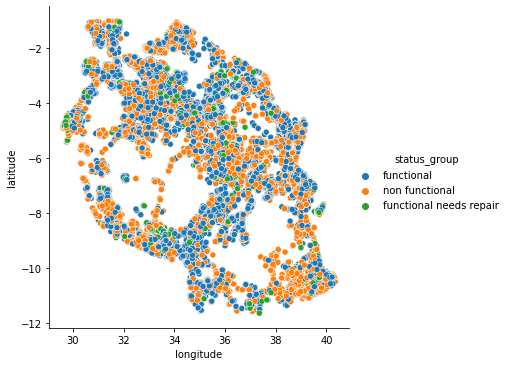

In [346]:
# filtered = train_data_df.loc[train_data_df['longitude'] > 0]



sns.relplot(x="longitude", y="latitude", hue="status_group", data=train_data_df)

In [347]:
# print(test_values_df.apply(lambda col: col.nunique()))

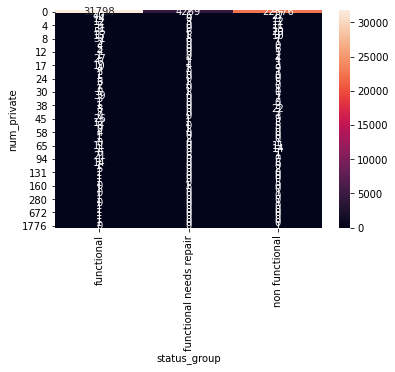

In [348]:
plot_heatmap(train_data_df, 'num_private','status_group')

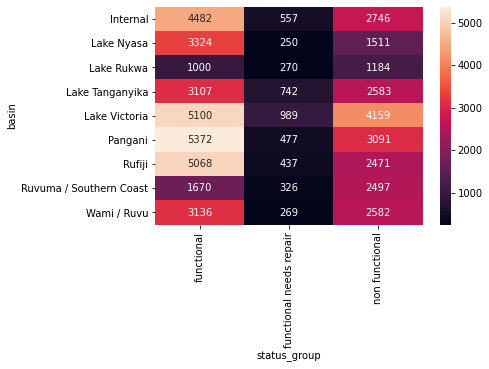

In [349]:
# pivot_table = train_data_df.pivot_table('id','basin','status_group',aggfunc='count').fillna(0).astype(int)
# sns.heatmap(pivot_table)

plot_heatmap(train_data_df, 'basin','status_group')

In [350]:
# one hot encode 'basin' column

def encode_basin(df):
    return pd.get_dummies(df,prefix=['basin'], columns = ['basin'], drop_first=False)

train_data_df = encode_basin(train_data_df)
test_values_df = encode_basin(test_values_df)

In [351]:
# these are now probably redundant since we have exact coordinates
def drop_other_location_data(df):
    return df.drop(['lga', 'ward'], axis=1, inplace=False)

train_data_df = drop_other_location_data(train_data_df)
test_values_df = drop_other_location_data(test_values_df)

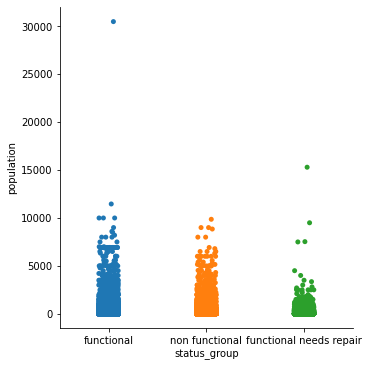

In [352]:
sns.catplot(x="status_group", y="population", data=train_data_df)

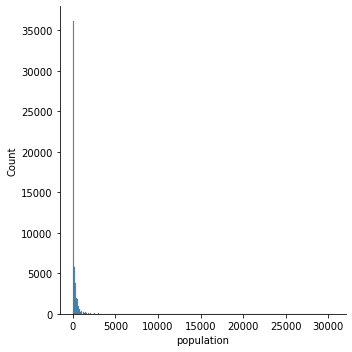

In [353]:
sns.displot(train_data_df, x="population",binwidth=100)

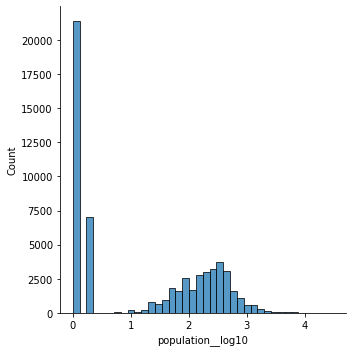

In [354]:
# log10 transform population column

def log10_transform_population(df):
    df['population'] = df['population'].apply(lambda x: x + 1)    # to avoid errors in log function
    df['population__log10'] = np.log10(df['population'])
    return df.drop('population', axis=1, inplace=False)

train_data_df = log10_transform_population(train_data_df)
test_values_df = log10_transform_population(test_values_df)
sns.displot(train_data_df, x="population__log10")

In [355]:
# re-encode public_meeting column
# True ->1
# False -> -1
# Missing -> 0

def encode_public_meeting(df):
    df["public_meeting"] = df["public_meeting"].astype('float')
    df['public_meeting'] = df['public_meeting'].apply(lambda x: -1 if x==0 else (x if x==1 else 0)) 
    return df

train_data_df = encode_public_meeting(train_data_df)
test_values_df = encode_public_meeting(test_values_df)


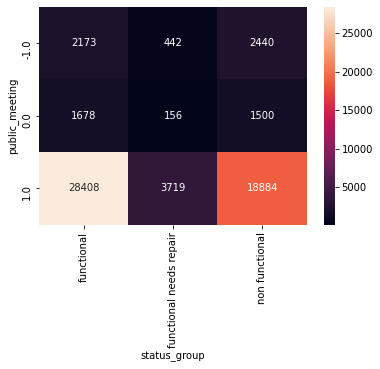

In [356]:
# pivot_table = train_data_df.pivot_table('id','public_meeting','status_group',aggfunc='count').fillna(0).astype(int)
# sns.heatmap(pivot_table, annot=True, fmt="d")

plot_heatmap(train_data_df, 'public_meeting','status_group')

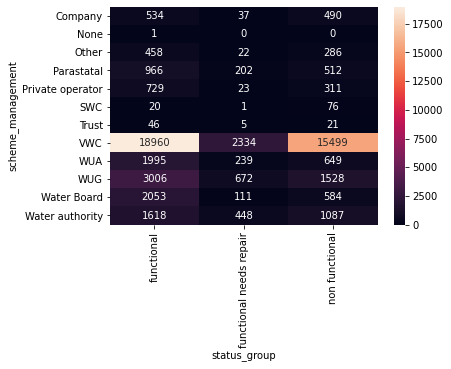

In [357]:
# pivot_table = train_data_df.pivot_table('id','scheme_management','status_group',aggfunc='count').fillna(0).astype(int)
# sns.heatmap(pivot_table, annot=True, fmt="d")

plot_heatmap(train_data_df, 'scheme_management','status_group')

In [358]:
# scheme_management is too skewed towards VWC value
# we can drop it

train_data_df.drop('scheme_management', axis=1, inplace=True)
test_values_df.drop('scheme_management', axis=1, inplace=True)

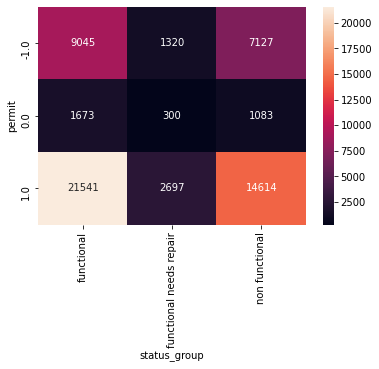

In [359]:
# encode permit column same as public_meeting column

def encode_permit(df):
    df["permit"] = df["permit"].astype('float')
    df['permit'] = df['permit'].apply(lambda x: -1 if x==0 else (x if x==1 else 0)) 
    return df

train_data_df = encode_permit(train_data_df)
test_values_df = encode_permit(test_values_df)


plot_heatmap(train_data_df, 'permit','status_group')

In [360]:
# plot_heatmap(train_data_df, 'extraction_type','extraction_type_class')

# lets keep extraction_type_class and drop extraction_type and extraction_type_group. 
# This is because extraction_type_class also captures the same information and it has low cardinality which can be suitable for one hot encoding.
# After experimenting we can decide whether we should keep extraction_type and extraction_typ_group

def encode_extraction_data(df):
    df.drop('extraction_type', axis=1, inplace=True)
    df.drop('extraction_type_group', axis=1, inplace=True)

    return pd.get_dummies(df,prefix=['extraction_type_class'], columns = ['extraction_type_class'], drop_first=False)

train_data_df = encode_extraction_data(train_data_df)
test_values_df = encode_extraction_data(test_values_df)

train_data_df.head()

,id,longitude,latitude,num_private,region_code,district_code,public_meeting,permit,management,management_group,payment,payment_type,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group,status_group,date_recorded__relative,funder_installer__freq,basin_Internal,basin_Lake Nyasa,basin_Lake Rukwa,basin_Lake Tanganyika,basin_Lake Victoria,basin_Pangani,basin_Rufiji,basin_Ruvuma / Southern Coast,basin_Wami / Ruvu,population__log10,extraction_type_class_gravity,extraction_type_class_handpump,extraction_type_class_motorpump,extraction_type_class_other,extraction_type_class_rope pump,extraction_type_class_submersible,extraction_type_class_wind-powered
0,69572,34.938093,-9.856322,0,11,5,1.0,-1.0,vwc,user-group,pay annually,annually,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe,functional,3073,0.001566,0,1,0,0,0,0,0,0,0,2.041393,1,0,0,0,0,0,0
1,8776,34.698766,-2.147466,0,20,2,0.0,1.0,wug,user-group,never pay,never pay,soft,good,insufficient,insufficient,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe,functional,3796,0.000657,0,0,0,0,1,0,0,0,0,2.448706,1,0,0,0,0,0,0
2,34310,37.460664,-3.821329,0,21,4,1.0,1.0,vwc,user-group,pay per bucket,per bucket,soft,good,enough,enough,dam,dam,surface,communal standpipe multiple,communal standpipe,functional,3787,0.000135,0,0,0,0,0,1,0,0,0,2.399674,1,0,0,0,0,0,0
3,67743,38.486161,-11.155298,0,90,63,1.0,1.0,vwc,user-group,never pay,never pay,soft,good,dry,dry,machine dbh,borehole,groundwater,communal standpipe multiple,communal standpipe,non functional,3759,0.003721,0,0,0,0,0,0,0,1,0,1.770852,0,0,0,0,0,1,0
4,19728,31.130847,-1.825359,0,18,1,1.0,1.0,other,other,never pay,never pay,soft,good,seasonal,seasonal,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe,functional,3194,0.000017,0,0,0,0,1,0,0,0,0,0.000000,1,0,0,0,0,0,0


In [361]:
# plot_heatmap(train_data_df, 'management','management_group')

def encode_management_data(df):
    df.drop('management', axis=1, inplace=True)
    return pd.get_dummies(df,prefix=['management_group'], columns = ['management_group'], drop_first=False)

train_data_df = encode_management_data(train_data_df)
test_values_df = encode_management_data(test_values_df)

train_data_df.head()

,id,longitude,latitude,num_private,region_code,district_code,public_meeting,permit,payment,payment_type,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group,status_group,date_recorded__relative,funder_installer__freq,basin_Internal,basin_Lake Nyasa,basin_Lake Rukwa,basin_Lake Tanganyika,basin_Lake Victoria,basin_Pangani,basin_Rufiji,basin_Ruvuma / Southern Coast,basin_Wami / Ruvu,population__log10,extraction_type_class_gravity,extraction_type_class_handpump,extraction_type_class_motorpump,extraction_type_class_other,extraction_type_class_rope pump,extraction_type_class_submersible,extraction_type_class_wind-powered,management_group_commercial,management_group_other,management_group_parastatal,management_group_unknown,management_group_user-group
0,69572,34.938093,-9.856322,0,11,5,1.0,-1.0,pay annually,annually,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe,functional,3073,0.001566,0,1,0,0,0,0,0,0,0,2.041393,1,0,0,0,0,0,0,0,0,0,0,1
1,8776,34.698766,-2.147466,0,20,2,0.0,1.0,never pay,never pay,soft,good,insufficient,insufficient,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe,functional,3796,0.000657,0,0,0,0,1,0,0,0,0,2.448706,1,0,0,0,0,0,0,0,0,0,0,1
2,34310,37.460664,-3.821329,0,21,4,1.0,1.0,pay per bucket,per bucket,soft,good,enough,enough,dam,dam,surface,communal standpipe multiple,communal standpipe,functional,3787,0.000135,0,0,0,0,0,1,0,0,0,2.399674,1,0,0,0,0,0,0,0,0,0,0,1
3,67743,38.486161,-11.155298,0,90,63,1.0,1.0,never pay,never pay,soft,good,dry,dry,machine dbh,borehole,groundwater,communal standpipe multiple,communal standpipe,non functional,3759,0.003721,0,0,0,0,0,0,0,1,0,1.770852,0,0,0,0,0,1,0,0,0,0,0,1
4,19728,31.130847,-1.825359,0,18,1,1.0,1.0,never pay,never pay,soft,good,seasonal,seasonal,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe,functional,3194,0.000017,0,0,0,0,1,0,0,0,0,0.000000,1,0,0,0,0,0,0,0,1,0,0,0


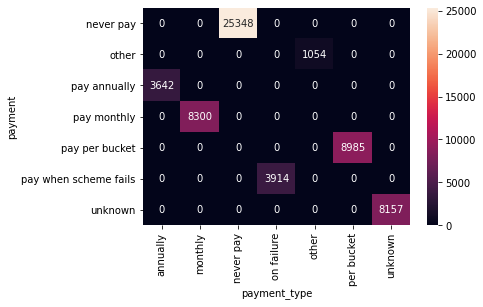

In [362]:
plot_heatmap(train_data_df, 'payment','payment_type')

'payment', 'payment_type' both are the same thing.

we can drop one column, and one hot encode other

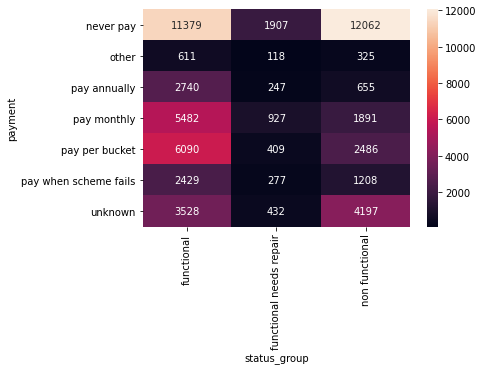

In [363]:
plot_heatmap(train_data_df, 'payment','status_group')

In [364]:

def encode_payment_data(df):
    df.drop('payment_type', axis=1, inplace=True)
    return pd.get_dummies(df,prefix=['payment'], columns = ['payment'], drop_first=False)

train_data_df = encode_payment_data(train_data_df)
test_values_df = encode_payment_data(test_values_df)

train_data_df.head()

,id,longitude,latitude,num_private,region_code,district_code,public_meeting,permit,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group,status_group,date_recorded__relative,funder_installer__freq,basin_Internal,basin_Lake Nyasa,basin_Lake Rukwa,basin_Lake Tanganyika,basin_Lake Victoria,basin_Pangani,basin_Rufiji,basin_Ruvuma / Southern Coast,basin_Wami / Ruvu,population__log10,extraction_type_class_gravity,extraction_type_class_handpump,extraction_type_class_motorpump,extraction_type_class_other,extraction_type_class_rope pump,extraction_type_class_submersible,extraction_type_class_wind-powered,management_group_commercial,management_group_other,management_group_parastatal,management_group_unknown,management_group_user-group,payment_never pay,payment_other,payment_pay annually,payment_pay monthly,payment_pay per bucket,payment_pay when scheme fails,payment_unknown
0,69572,34.938093,-9.856322,0,11,5,1.0,-1.0,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe,functional,3073,0.001566,0,1,0,0,0,0,0,0,0,2.041393,1,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0
1,8776,34.698766,-2.147466,0,20,2,0.0,1.0,soft,good,insufficient,insufficient,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe,functional,3796,0.000657,0,0,0,0,1,0,0,0,0,2.448706,1,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0
2,34310,37.460664,-3.821329,0,21,4,1.0,1.0,soft,good,enough,enough,dam,dam,surface,communal standpipe multiple,communal standpipe,functional,3787,0.000135,0,0,0,0,0,1,0,0,0,2.399674,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0
3,67743,38.486161,-11.155298,0,90,63,1.0,1.0,soft,good,dry,dry,machine dbh,borehole,groundwater,communal standpipe multiple,communal standpipe,non functional,3759,0.003721,0,0,0,0,0,0,0,1,0,1.770852,0,0,0,0,0,1,0,0,0,0,0,1,1,0,0,0,0,0,0
4,19728,31.130847,-1.825359,0,18,1,1.0,1.0,soft,good,seasonal,seasonal,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe,functional,3194,0.000017,0,0,0,0,1,0,0,0,0,0.000000,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0


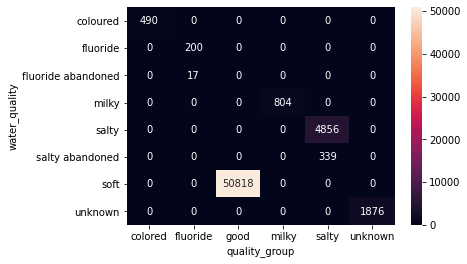

In [365]:

plot_heatmap(train_data_df, 'water_quality','quality_group')
# We can do same thing for water_quality and quality_group
# For now, keep quality_group since it captures the same information and its cradinality is low

In [366]:

def encode_water_quality(df):
  df.drop('water_quality', axis=1, inplace=True)
  return pd.get_dummies(df,prefix=['quality_group'], columns = ['quality_group'], drop_first=False)

train_data_df = encode_water_quality(train_data_df)
test_values_df = encode_water_quality(test_values_df)
train_data_df.head()

,id,longitude,latitude,num_private,region_code,district_code,public_meeting,permit,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group,status_group,date_recorded__relative,funder_installer__freq,basin_Internal,basin_Lake Nyasa,basin_Lake Rukwa,basin_Lake Tanganyika,basin_Lake Victoria,basin_Pangani,basin_Rufiji,basin_Ruvuma / Southern Coast,basin_Wami / Ruvu,population__log10,extraction_type_class_gravity,extraction_type_class_handpump,extraction_type_class_motorpump,extraction_type_class_other,extraction_type_class_rope pump,extraction_type_class_submersible,extraction_type_class_wind-powered,management_group_commercial,management_group_other,management_group_parastatal,management_group_unknown,management_group_user-group,payment_never pay,payment_other,payment_pay annually,payment_pay monthly,payment_pay per bucket,payment_pay when scheme fails,payment_unknown,quality_group_colored,quality_group_fluoride,quality_group_good,quality_group_milky,quality_group_salty,quality_group_unknown
0,69572,34.938093,-9.856322,0,11,5,1.0,-1.0,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe,functional,3073,0.001566,0,1,0,0,0,0,0,0,0,2.041393,1,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0
1,8776,34.698766,-2.147466,0,20,2,0.0,1.0,insufficient,insufficient,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe,functional,3796,0.000657,0,0,0,0,1,0,0,0,0,2.448706,1,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,1,0,0,0
2,34310,37.460664,-3.821329,0,21,4,1.0,1.0,enough,enough,dam,dam,surface,communal standpipe multiple,communal standpipe,functional,3787,0.000135,0,0,0,0,0,1,0,0,0,2.399674,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0
3,67743,38.486161,-11.155298,0,90,63,1.0,1.0,dry,dry,machine dbh,borehole,groundwater,communal standpipe multiple,communal standpipe,non functional,3759,0.003721,0,0,0,0,0,0,0,1,0,1.770852,0,0,0,0,0,1,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,1,0,0,0
4,19728,31.130847,-1.825359,0,18,1,1.0,1.0,seasonal,seasonal,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe,functional,3194,0.000017,0,0,0,0,1,0,0,0,0,0.000000,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0


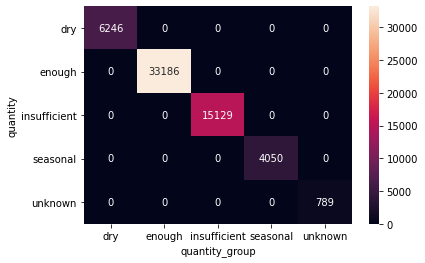

In [367]:
plot_heatmap(train_data_df, 'quantity','quantity_group')

quantity and quantity_group are the same thing

we can drop one and one hot encode the other

In [368]:
def encode_quantity(df):
    df.drop('quantity_group', axis=1, inplace=True)
    return pd.get_dummies(df,prefix=['quantity'], columns = ['quantity'], drop_first=False)

train_data_df = encode_quantity(train_data_df)
test_values_df = encode_quantity(test_values_df)

train_data_df.head()

,id,longitude,latitude,num_private,region_code,district_code,public_meeting,permit,source,source_type,source_class,waterpoint_type,waterpoint_type_group,status_group,date_recorded__relative,funder_installer__freq,basin_Internal,basin_Lake Nyasa,basin_Lake Rukwa,basin_Lake Tanganyika,basin_Lake Victoria,basin_Pangani,basin_Rufiji,basin_Ruvuma / Southern Coast,basin_Wami / Ruvu,population__log10,extraction_type_class_gravity,extraction_type_class_handpump,extraction_type_class_motorpump,extraction_type_class_other,extraction_type_class_rope pump,extraction_type_class_submersible,extraction_type_class_wind-powered,management_group_commercial,management_group_other,management_group_parastatal,management_group_unknown,management_group_user-group,payment_never pay,payment_other,payment_pay annually,payment_pay monthly,payment_pay per bucket,payment_pay when scheme fails,payment_unknown,quality_group_colored,quality_group_fluoride,quality_group_good,quality_group_milky,quality_group_salty,quality_group_unknown,quantity_dry,quantity_enough,quantity_insufficient,quantity_seasonal,quantity_unknown
0,69572,34.938093,-9.856322,0,11,5,1.0,-1.0,spring,spring,groundwater,communal standpipe,communal standpipe,functional,3073,0.001566,0,1,0,0,0,0,0,0,0,2.041393,1,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0
1,8776,34.698766,-2.147466,0,20,2,0.0,1.0,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe,functional,3796,0.000657,0,0,0,0,1,0,0,0,0,2.448706,1,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0
2,34310,37.460664,-3.821329,0,21,4,1.0,1.0,dam,dam,surface,communal standpipe multiple,communal standpipe,functional,3787,0.000135,0,0,0,0,0,1,0,0,0,2.399674,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0
3,67743,38.486161,-11.155298,0,90,63,1.0,1.0,machine dbh,borehole,groundwater,communal standpipe multiple,communal standpipe,non functional,3759,0.003721,0,0,0,0,0,0,0,1,0,1.770852,0,0,0,0,0,1,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0
4,19728,31.130847,-1.825359,0,18,1,1.0,1.0,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe,functional,3194,0.000017,0,0,0,0,1,0,0,0,0,0.000000,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0


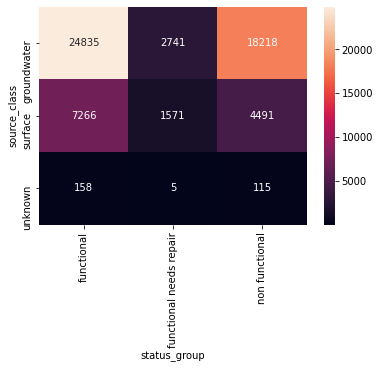

In [369]:
plot_heatmap(train_data_df,'source_class', 'status_group')

In [370]:

def encode_source(df):
    df.drop('source', axis=1, inplace=True)
    df.drop('source_type', axis=1, inplace=True)
    return pd.get_dummies(df,prefix=['source_class'], columns = ['source_class'], drop_first=False)

train_data_df = encode_source(train_data_df)
test_values_df = encode_source(test_values_df)

train_data_df.head()

,id,longitude,latitude,num_private,region_code,district_code,public_meeting,permit,waterpoint_type,waterpoint_type_group,status_group,date_recorded__relative,funder_installer__freq,basin_Internal,basin_Lake Nyasa,basin_Lake Rukwa,basin_Lake Tanganyika,basin_Lake Victoria,basin_Pangani,basin_Rufiji,basin_Ruvuma / Southern Coast,basin_Wami / Ruvu,population__log10,extraction_type_class_gravity,extraction_type_class_handpump,extraction_type_class_motorpump,extraction_type_class_other,extraction_type_class_rope pump,extraction_type_class_submersible,extraction_type_class_wind-powered,management_group_commercial,management_group_other,management_group_parastatal,management_group_unknown,management_group_user-group,payment_never pay,payment_other,payment_pay annually,payment_pay monthly,payment_pay per bucket,payment_pay when scheme fails,payment_unknown,quality_group_colored,quality_group_fluoride,quality_group_good,quality_group_milky,quality_group_salty,quality_group_unknown,quantity_dry,quantity_enough,quantity_insufficient,quantity_seasonal,quantity_unknown,source_class_groundwater,source_class_surface,source_class_unknown
0,69572,34.938093,-9.856322,0,11,5,1.0,-1.0,communal standpipe,communal standpipe,functional,3073,0.001566,0,1,0,0,0,0,0,0,0,2.041393,1,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0
1,8776,34.698766,-2.147466,0,20,2,0.0,1.0,communal standpipe,communal standpipe,functional,3796,0.000657,0,0,0,0,1,0,0,0,0,2.448706,1,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0
2,34310,37.460664,-3.821329,0,21,4,1.0,1.0,communal standpipe multiple,communal standpipe,functional,3787,0.000135,0,0,0,0,0,1,0,0,0,2.399674,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0
3,67743,38.486161,-11.155298,0,90,63,1.0,1.0,communal standpipe multiple,communal standpipe,non functional,3759,0.003721,0,0,0,0,0,0,0,1,0,1.770852,0,0,0,0,0,1,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0
4,19728,31.130847,-1.825359,0,18,1,1.0,1.0,communal standpipe,communal standpipe,functional,3194,0.000017,0,0,0,0,1,0,0,0,0,0.000000,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,1,0


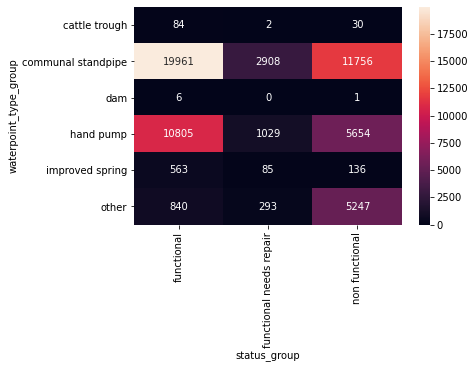

In [371]:
plot_heatmap(train_data_df,'waterpoint_type_group', 'status_group')

In [372]:
def encode_waterpoint(df):
    df.drop('waterpoint_type', axis=1, inplace=True)
    return pd.get_dummies(df,prefix=['waterpoint_type_group'], columns = ['waterpoint_type_group'], drop_first=False)

train_data_df = encode_waterpoint(train_data_df)
test_values_df = encode_waterpoint(test_values_df)

train_data_df.head()

,id,longitude,latitude,num_private,region_code,district_code,public_meeting,permit,status_group,date_recorded__relative,funder_installer__freq,basin_Internal,basin_Lake Nyasa,basin_Lake Rukwa,basin_Lake Tanganyika,basin_Lake Victoria,basin_Pangani,basin_Rufiji,basin_Ruvuma / Southern Coast,basin_Wami / Ruvu,population__log10,extraction_type_class_gravity,extraction_type_class_handpump,extraction_type_class_motorpump,extraction_type_class_other,extraction_type_class_rope pump,extraction_type_class_submersible,extraction_type_class_wind-powered,management_group_commercial,management_group_other,management_group_parastatal,management_group_unknown,management_group_user-group,payment_never pay,payment_other,payment_pay annually,payment_pay monthly,payment_pay per bucket,payment_pay when scheme fails,payment_unknown,quality_group_colored,quality_group_fluoride,quality_group_good,quality_group_milky,quality_group_salty,quality_group_unknown,quantity_dry,quantity_enough,quantity_insufficient,quantity_seasonal,quantity_unknown,source_class_groundwater,source_class_surface,source_class_unknown,waterpoint_type_group_cattle trough,waterpoint_type_group_communal standpipe,waterpoint_type_group_dam,waterpoint_type_group_hand pump,waterpoint_type_group_improved spring,waterpoint_type_group_other
0,69572,34.938093,-9.856322,0,11,5,1.0,-1.0,functional,3073,0.001566,0,1,0,0,0,0,0,0,0,2.041393,1,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0
1,8776,34.698766,-2.147466,0,20,2,0.0,1.0,functional,3796,0.000657,0,0,0,0,1,0,0,0,0,2.448706,1,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,0
2,34310,37.460664,-3.821329,0,21,4,1.0,1.0,functional,3787,0.000135,0,0,0,0,0,1,0,0,0,2.399674,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0
3,67743,38.486161,-11.155298,0,90,63,1.0,1.0,non functional,3759,0.003721,0,0,0,0,0,0,0,1,0,1.770852,0,0,0,0,0,1,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0
4,19728,31.130847,-1.825359,0,18,1,1.0,1.0,functional,3194,0.000017,0,0,0,0,1,0,0,0,0,0.000000,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,0,0


In [373]:
train_data_df.drop(['num_private'], axis=1, inplace=True)
test_values_df.drop(['num_private'], axis=1, inplace=True)

train_data_df.head()

,id,longitude,latitude,region_code,district_code,public_meeting,permit,status_group,date_recorded__relative,funder_installer__freq,basin_Internal,basin_Lake Nyasa,basin_Lake Rukwa,basin_Lake Tanganyika,basin_Lake Victoria,basin_Pangani,basin_Rufiji,basin_Ruvuma / Southern Coast,basin_Wami / Ruvu,population__log10,extraction_type_class_gravity,extraction_type_class_handpump,extraction_type_class_motorpump,extraction_type_class_other,extraction_type_class_rope pump,extraction_type_class_submersible,extraction_type_class_wind-powered,management_group_commercial,management_group_other,management_group_parastatal,management_group_unknown,management_group_user-group,payment_never pay,payment_other,payment_pay annually,payment_pay monthly,payment_pay per bucket,payment_pay when scheme fails,payment_unknown,quality_group_colored,quality_group_fluoride,quality_group_good,quality_group_milky,quality_group_salty,quality_group_unknown,quantity_dry,quantity_enough,quantity_insufficient,quantity_seasonal,quantity_unknown,source_class_groundwater,source_class_surface,source_class_unknown,waterpoint_type_group_cattle trough,waterpoint_type_group_communal standpipe,waterpoint_type_group_dam,waterpoint_type_group_hand pump,waterpoint_type_group_improved spring,waterpoint_type_group_other
0,69572,34.938093,-9.856322,11,5,1.0,-1.0,functional,3073,0.001566,0,1,0,0,0,0,0,0,0,2.041393,1,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0
1,8776,34.698766,-2.147466,20,2,0.0,1.0,functional,3796,0.000657,0,0,0,0,1,0,0,0,0,2.448706,1,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,0
2,34310,37.460664,-3.821329,21,4,1.0,1.0,functional,3787,0.000135,0,0,0,0,0,1,0,0,0,2.399674,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0
3,67743,38.486161,-11.155298,90,63,1.0,1.0,non functional,3759,0.003721,0,0,0,0,0,0,0,1,0,1.770852,0,0,0,0,0,1,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0
4,19728,31.130847,-1.825359,18,1,1.0,1.0,functional,3194,0.000017,0,0,0,0,1,0,0,0,0,0.000000,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,0,0


In [374]:
status_group_encoded = pd.factorize(train_data_df['status_group'])
train_data_df.status_group = status_group_encoded[0]


In [375]:
train_data_df.head()

,id,longitude,latitude,region_code,district_code,public_meeting,permit,status_group,date_recorded__relative,funder_installer__freq,basin_Internal,basin_Lake Nyasa,basin_Lake Rukwa,basin_Lake Tanganyika,basin_Lake Victoria,basin_Pangani,basin_Rufiji,basin_Ruvuma / Southern Coast,basin_Wami / Ruvu,population__log10,extraction_type_class_gravity,extraction_type_class_handpump,extraction_type_class_motorpump,extraction_type_class_other,extraction_type_class_rope pump,extraction_type_class_submersible,extraction_type_class_wind-powered,management_group_commercial,management_group_other,management_group_parastatal,management_group_unknown,management_group_user-group,payment_never pay,payment_other,payment_pay annually,payment_pay monthly,payment_pay per bucket,payment_pay when scheme fails,payment_unknown,quality_group_colored,quality_group_fluoride,quality_group_good,quality_group_milky,quality_group_salty,quality_group_unknown,quantity_dry,quantity_enough,quantity_insufficient,quantity_seasonal,quantity_unknown,source_class_groundwater,source_class_surface,source_class_unknown,waterpoint_type_group_cattle trough,waterpoint_type_group_communal standpipe,waterpoint_type_group_dam,waterpoint_type_group_hand pump,waterpoint_type_group_improved spring,waterpoint_type_group_other
0,69572,34.938093,-9.856322,11,5,1.0,-1.0,0,3073,0.001566,0,1,0,0,0,0,0,0,0,2.041393,1,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0
1,8776,34.698766,-2.147466,20,2,0.0,1.0,0,3796,0.000657,0,0,0,0,1,0,0,0,0,2.448706,1,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,0
2,34310,37.460664,-3.821329,21,4,1.0,1.0,0,3787,0.000135,0,0,0,0,0,1,0,0,0,2.399674,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0
3,67743,38.486161,-11.155298,90,63,1.0,1.0,1,3759,0.003721,0,0,0,0,0,0,0,1,0,1.770852,0,0,0,0,0,1,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0
4,19728,31.130847,-1.825359,18,1,1.0,1.0,0,3194,0.000017,0,0,0,0,1,0,0,0,0,0.000000,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,0,0


# Grid Search

In [376]:
# # Create the parameter grid based on the results of random search 
# param_grid = {
#     'bootstrap': [True, False],
#     'max_depth': [80, 90, 100, 110, None],
#     'max_features': ['auto', 'log2', None],
#     'min_samples_leaf': [3, 4, 5],
#     'min_samples_split': [2, 5, 10],
#     'n_estimators': [100, 200, 300, 1000]
# }
# # Create a based model
# grid_search_classifier = RandomForestClassifier()
# # Instantiate the grid search model
# grid_search = RandomizedSearchCV(estimator = grid_search_classifier, param_distributions  = param_grid, n_iter = 5,
#                           cv = 5, n_jobs = -1, verbose = 2)
# grid_search.fit(train_data_df.drop(['id','status_group'], axis=1), train_data_df['status_group'])


In [377]:
# print(grid_search.best_params_)

# best_grid = grid_search.best_estimator_
# print(f'TRAIN ACCURACY OF THE best grid search MODEL:  {best_grid.score(train_data_df.drop(['id','status_group'], axis=1), train_data_df['status_group'])}')


# Single Random Forest

In [378]:
#Splitting the data into independent and dependent variables

y = train_data_df['status_group']
X = train_data_df.drop(['id','status_group'], axis=1)

test_data_ids = test_values_df['id']
test_data_df = test_values_df.drop('id', axis=1)

X_train, X_validation, y_train, y_validation = train_test_split(X, y, test_size = 0.25, random_state = 5, stratify=y)


In [379]:
classifier = RandomForestClassifier(n_estimators = 1000, random_state = 6, min_samples_leaf=3)
classifier.fit(X_train, y_train)


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=3, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=1000,
                       n_jobs=None, oob_score=False, random_state=6, verbose=0,
                       warm_start=False)

In [380]:
print(f'TRAIN ACCURACY OF THE MODEL:  {classifier.score(X_train, y_train)}')


TRAIN ACCURACY OF THE MODEL:  0.8657463524130191


In [381]:
y_validation_pred = classifier.predict(X_validation)

print('Text Accuracy: ')
accuracy_score(y_validation, y_validation_pred)


Text Accuracy: 


0.8018181818181818

In [382]:
print('Text Accuracy for Test Data: ')
print(classification_report(y_validation, y_validation_pred))

Text Accuracy for Test Data: 
              precision    recall  f1-score   support

           0       0.78      0.92      0.84      8065
           1       0.85      0.75      0.79      5706
           2       0.65      0.24      0.35      1079

    accuracy                           0.80     14850
   macro avg       0.76      0.63      0.66     14850
weighted avg       0.80      0.80      0.79     14850



### Train a new classifier again with full dataset to predict test dataset

In [383]:
new_classifier = RandomForestClassifier(n_estimators = 1000, random_state = 6, min_samples_leaf=3)
new_classifier.fit(X, y)

test_data_pred = new_classifier.predict(test_data_df)
test_result = pd.concat([test_data_ids, pd.DataFrame(test_data_pred)], axis=1)
test_data_pred

array([1, 0, 0, ..., 0, 0, 1])

In [384]:
test_result.columns = ['id', 'status_group']
test_result

,id,status_group
0,50785,1
1,51630,0
2,17168,0
3,45559,1
4,49871,0
...,...,...
14845,39307,1
14846,18990,0
14847,28749,0
14848,33492,0


In [385]:
test_result['status_group'] = test_result['status_group'].apply(lambda x: 'functional' if x==0 else ('non functional' if x==1 else 'functional needs repair'))
test_result

,id,status_group
0,50785,non functional
1,51630,functional
2,17168,functional
3,45559,non functional
4,49871,functional
...,...,...
14845,39307,non functional
14846,18990,functional
14847,28749,functional
14848,33492,functional


In [386]:
test_result.to_csv('submission.csv', sep=',', index=False)

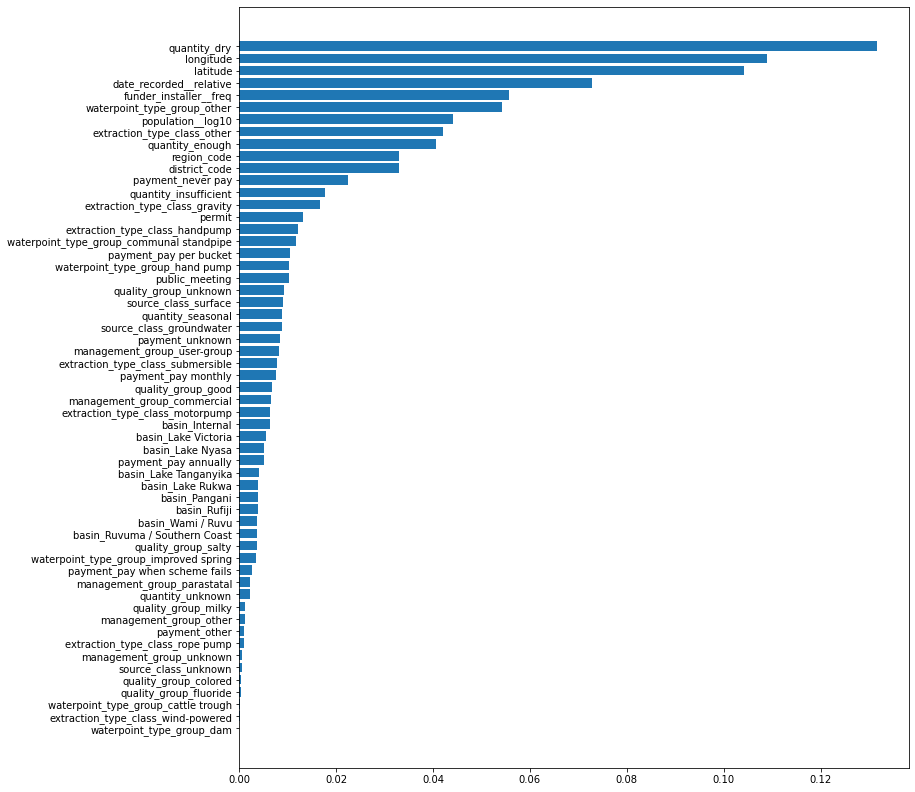

In [387]:
importances = new_classifier.feature_importances_
indices = np.argsort(importances)

fig, ax = plt.subplots()
fig.set_size_inches(12, 14)
ax.barh(range(len(importances)), importances[indices])
ax.set_yticks(range(len(importances)))
_ = ax.set_yticklabels(np.array(X_train.columns)[indices])

# Other Stuff

In [388]:

# one hot encode 'scheme_management' column

# train_data_df = pd.get_dummies(train_data_df,prefix=['basin'], columns = ['basin'], drop_first=False)

In [389]:
# train_data_df.loc[train_data_df['longitude'] == 0]

In [390]:
# test_values_df.info()
# print(test_values_df.apply(lambda col: (col == 0).sum()))

In [391]:
# sns.countplot(x="status_group", data=train_data_df.loc[train_data_df['longitude'] == 0])

In [392]:
# train_data_df['log10_amount_tsh'] = np.log10(train_data_df['amount_tsh'])
# sns.catplot(x="status_group", y="log10_amount_tsh", data=train_data_df)

In [393]:
# train_data_df['construction_year'].value_counts()
# filtered = train_data_df.loc[train_data_df['construction_year'] > 0]
# sns.catplot(x="status_group", y="construction_year", data=filtered)

In [394]:
# filtered = train_data_df.loc[train_data_df['longitude'] > 0]
# sns.relplot(x="longitude", y="latitude", hue="status_group", data=filtered)


In [395]:
# pivot_table = train_data_df.pivot_table('id','waterpoint_type','status_group',aggfunc='count').fillna(0).astype(int)
# sns.heatmap(pivot_table)
